In [1]:
%config Completer.use_jedi = False

In [3]:
import ipywidgets as widgets
import pandas as pd
from datetime import datetime

import pandas as pd

import matplotlib.pyplot as plt

import glob

import numpy as np

# NIFTY Index time series analysis

### Load and join all Nifty OHLC

In [4]:
data_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob('../Data/Nifty/OHLC/*.csv',)], 
                    join='outer')

In [5]:
data_df.head()

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
Date,,,,,,
2018-01-02,10477.55,10495.2,10404.65,10442.20,158092430,8665.47
2018-01-03,10482.65,10503.6,10429.55,10443.20,172516859,9541.60
2018-01-04,10469.40,10513.0,10441.45,10504.80,180257392,9561.95
2018-01-05,10534.25,10566.1,10520.10,10558.85,186469717,10306.22
2018-01-08,10591.70,10631.2,10588.55,10623.60,174181231,9907.27


### Data Sanity Checks

#TODO check for missing data

In [6]:
# Check for duplicates
data_df.duplicated().sum()

0

In [123]:
def print_date_range(date_range):
     print(date_range)

widgets.interact(
    df = print_date_range,
    date_range=selection_range_slider
);

interactive(children=(SelectionRangeSlider(description='Dates', index=(13, 22), layout=Layout(width='500px'), …

## Stationarity and differencing

#### Raw

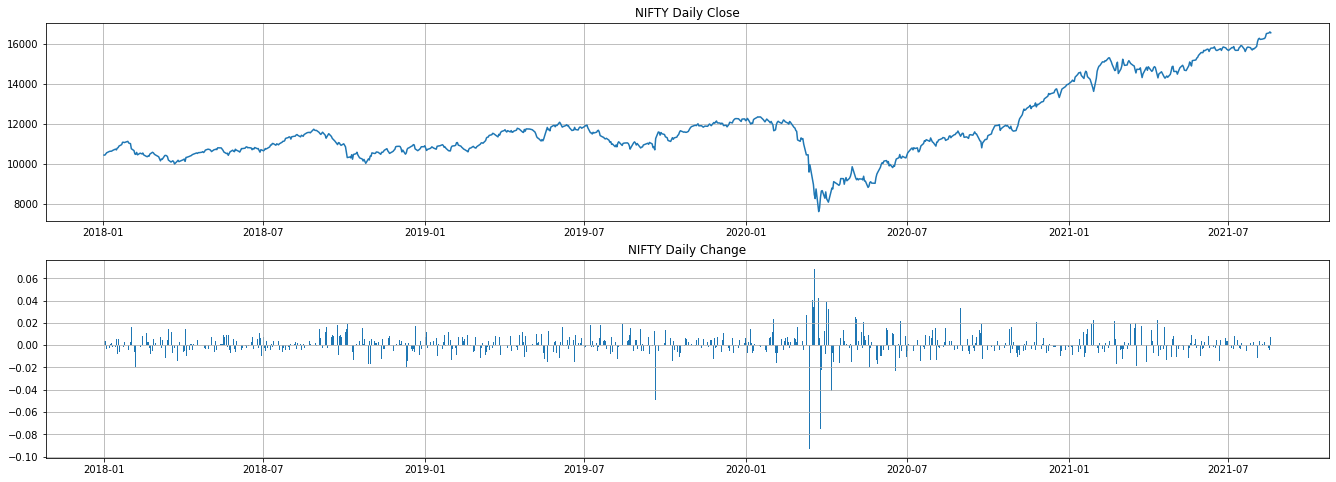

In [7]:
fig = plt.figure(figsize=(23,8))
ax = fig.add_subplot(211)
ax.plot(data_df.Close)
ax.grid()
ax.set_title('NIFTY Daily Close')
# fig = plt.figure(figsize=(23,5))
ax = fig.add_subplot(212)
ax.bar(data_df.index, (data_df.Open - data_df.Close)/data_df.Open)
ax.set_title('NIFTY Daily Change')
ax.grid()

#### Stationarization and Differencing

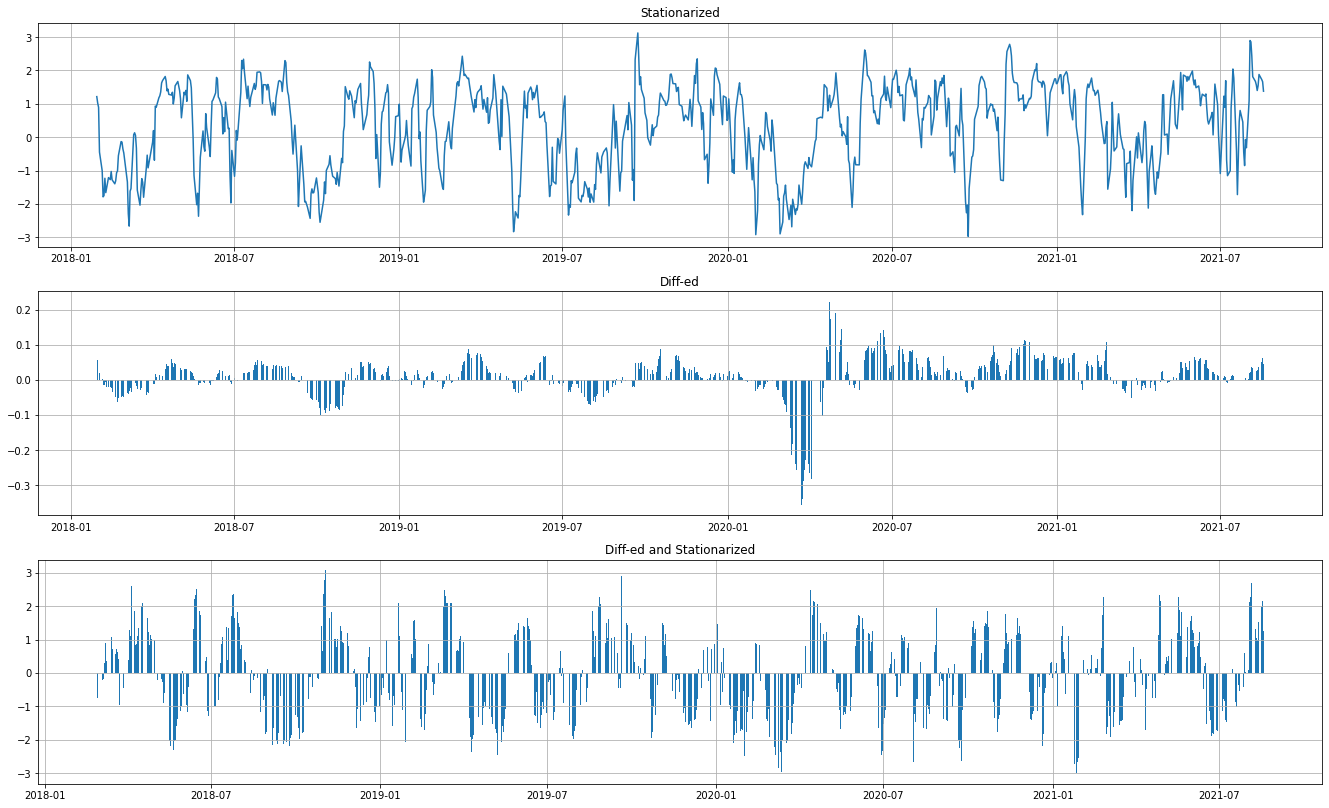

In [26]:
fig = plt.figure(figsize=(23,14))
ax = fig.add_subplot(311)
ax.plot(data_df.Close.rolling(20).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()
ax.set_title('Stationarized')
ax = fig.add_subplot(312)
ax.bar(data_df.index, data_df.Close.rolling(20).apply(lambda x: (x[-1]-x[0])/x[0]))
ax.set_title('Diff-ed')
ax.grid()
ax = fig.add_subplot(313)
ax.bar(data_df.index, data_df.Close.rolling(20).apply(lambda x: (x[-1]-x[0])).rolling(20).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.set_title('Diff-ed and Stationarized')
# ax.bar(data_df.index, (data_df.Open - data_df.Close).rolling(20).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()

# Period Rate of Change Analysis

Since this is dependent on the option's expiry date we are  choosing the number of trading days left as the period.

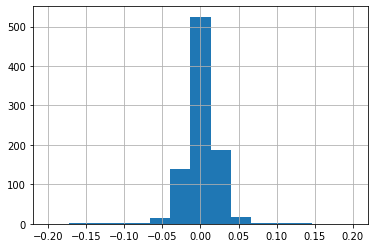

In [12]:
trade_days_left = 4 # used as window size
period_change = data_df.Close.rolling(trade_days_left).apply(lambda x: (x[-1]-x[0])/x[0]).dropna()
plt.hist(period_change, bins=15, range=(-0.2,0.2))
plt.grid()

In [13]:
period_change.mean()

0.0017819560610777855

In [14]:
period_change.std()

0.021721102059972883

In [15]:
(period_change>0).sum()/len(period_change)

0.5720670391061452

In [16]:
(period_change<0).sum()/len(period_change)

0.42793296089385474

Over the time period 57% of all changes were positive 42.5% were negative

In [17]:
expected_change_neg_sigma = period_change.mean() - period_change.std()
prob_change_neg_sigma = (period_change<expected_change_neg_sigma).sum()/len(period_change)
print("%.3f probability of < %.2f%% change" %(prob_change_neg_sigma, expected_change_neg_sigma*100))

0.104 probability of < -1.99% change


In [18]:
expected_change_pos_sigma = period_change.mean() + period_change.std()
prob_change_pos_sigma = (period_change>expected_change_pos_sigma).sum()/len(period_change)
print("%.3f probability of > %.f%% change" %(prob_change_pos_sigma, expected_change_pos_sigma*100))

0.083 probability of > 2% change


In [19]:
expected_change = 0.01
prob_change = (period_change>expected_change).sum()/len(period_change)
print("%.3f probability of > %.f%% change" %(prob_change, expected_change*100))

0.313 probability of > 1% change


In [20]:
expected_change = -0.01
prob_change = (period_change<expected_change).sum()/len(period_change)
print("%.3f probability of < %.f%% change" %(prob_change, expected_change*100))

0.230 probability of < -1% change


In [22]:
# Set the last price
last_price = 16600

## Options Chain Analysis

In [27]:
options_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob('../Data/Nifty/Options//*.csv',)], 
                    join='outer')

In [28]:
# Filter for latest data
options_df = options_df[options_df.index.max()==options_df.index]

### Data Sanity Checks

In [29]:
options_df.columns

Index(['Symbol', 'Expiry', 'Option Type', 'Strike Price', 'Open', 'High',
       'Low', 'Close', 'LTP', 'Settle Price', 'No. of contracts',
       'Turnover in Lacs', 'Premium Turnover in Lacs', 'Open Int',
       'Change in OI', 'Underlying Value'],
      dtype='object')

In [30]:
# Check whether we got both PE and CE
options_df['Option Type'].unique()

array(['CE', 'PE'], dtype=object)

In [31]:
# Keep relevant Columns only
options_df = options_df[['Symbol', 'Strike Price', 'Option Type', 'Expiry', 'Close','No. of contracts']]

In [32]:
options_df.shape

(172, 6)

In [33]:
sum(options_df['No. of contracts']>1000)

88

In [34]:
# Get rid of contracts which are not actively traded
options_df = options_df[options_df['No. of contracts']>1000]

### Calculate the probabilty of expiry above the strike price

We want to calculate:
- How much change is required in the underlying in order for a contract to expire ITM
- What is the probability of the underlying price changing by that much before expiry

In [48]:
# Filter out ITM
ce_df = ce_df[ce_df['Strike Price']>last_price]
pe_df = pe_df[pe_df['Strike Price']<last_price]

# Separate out Call and Put option
ce_df = options_df[options_df['Option Type']=='CE']
pe_df = options_df[options_df['Option Type']=='PE']

ce_df = ce_df.sort_values('Strike Price')
pe_df = pe_df.sort_values('Strike Price')

# Filter ITM options
ce_df = ce_df[ce_df['Strike Price']>last_price]
pe_df = pe_df[pe_df['Strike Price']<last_price]


# Change percent
ce_change = ((ce_df['Strike Price'] - last_price)/last_price).values
pe_change = ((pe_df['Strike Price'] - last_price)/last_price).values

# Calculate Probabilty of out of the money call options expiring in the money
proba_atm_expiry_ce = np.zeros_like(ce_change)
for idx in range(len(ce_df)):
    proba_atm_expiry_ce[idx] = np.apply_along_axis(lambda x : x > ce_change[idx],
                                                   axis=0,
                                                   arr=period_change).mean()

strike_price_ce = ce_df['Strike Price'].values

# Calculate Probabilty of out of the money put options expiring in the moeny
proba_atm_expiry_pe = np.zeros_like(pe_change)
for idx in range(len(pe_df)):
    proba_atm_expiry_pe[idx] = np.apply_along_axis(lambda x : x < pe_change[idx],
                                                axis=0,
                                                arr=period_change).mean()

strike_price_pe = pe_df['Strike Price'].values

### Probabilty vs Cost
Lets visualize the probability of ITM expiry and the cost of investing in one lot of the contract.

Text(0.5, 1.0, 'Cost = CE Price x Lot')

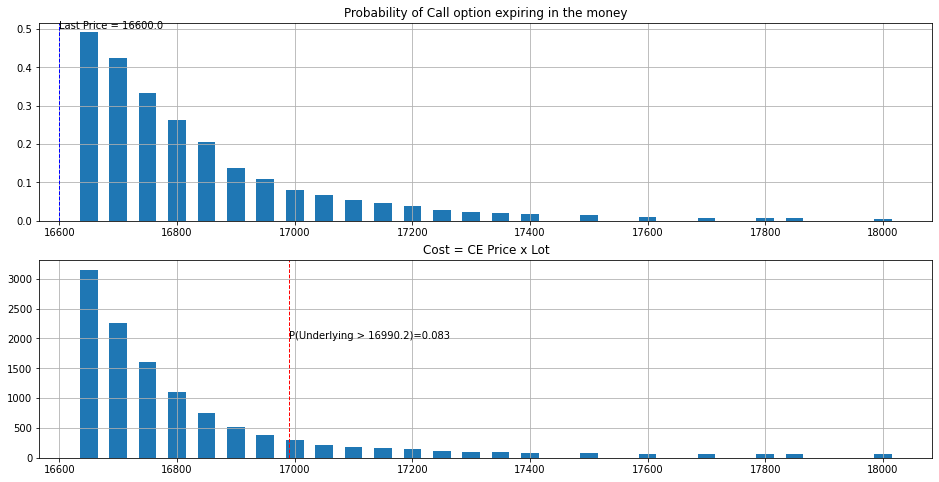

In [69]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(211)
ax.bar(x=strike_price_ce, height=proba_atm_expiry_ce, width=30)
ax.grid()
ax.set_title('Probability of Call option expiring in the money')
plt.axvline(x=last_price, color='b', linewidth=1.0, linestyle='--')
plt.text(last_price,
         0.5,
         'Last Price = %.1f'%last_price, 
         rotation=0)
ax = fig.add_subplot(212)
ax.bar(x=strike_price_ce, height=50*ce_df['Close'].values, width=30)
ax.grid(which='major')

sigma_high = last_price*(1+expected_change_pos_sigma)
plt.axvline(x=sigma_high, color='r', linewidth=1.0, linestyle='--')
plt.text(sigma_high,
         2000,
         'P(Underlying > %.1f)=%.3f'%(sigma_high,prob_change_pos_sigma), 
         rotation=0)

ax.set_title('Cost = CE Price x Lot')



In [ ]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(211)
ax.bar(x=strike_price_pe, height=proba_atm_expiry_pe, width=30)
ax.grid()
ax.set_title('Probability of Put option expring  in the money (PE)')
plt.axvline(x=last_price, color='b', linewidth=1.0, linestyle='--')
plt.text(last_price+10,
         0.15,
         'Last Price = %.1f'%last_price, 
         rotation=0)
ax = fig.add_subplot(212)
ax.bar(x=strike_price_pe, height=50*pe_df['Close'].values, width=30)
ax.grid(which='major')
sigma_low = last_price*(1+expected_change_neg_sigma)
plt.axvline(x=sigma_low, color='r', linewidth=1.0, linestyle='--')
plt.text(sigma_low,
         2000,
         'P(Underlying < %.1f)=%.3f'%(sigma_low,prob_change_neg_sigma), 
         rotation=0)

ax.set_title('Cost =PE Price x Lot')

Putting it all together

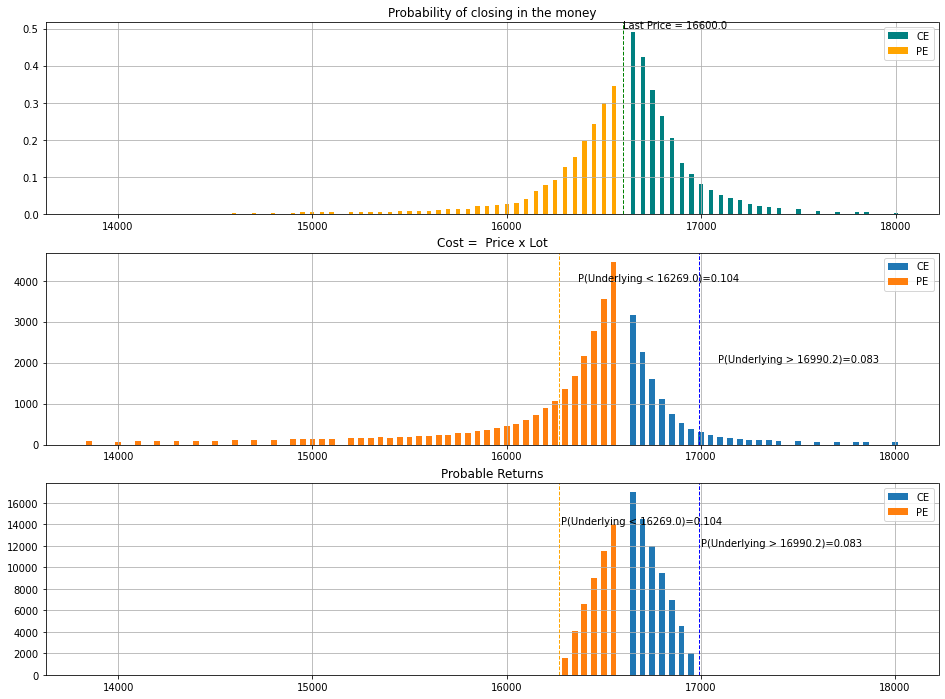

In [113]:
fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(311)

# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_atm_expiry_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE')

# Plot PE
ax.bar(x=strike_price_pe, height=proba_atm_expiry_pe, 
       width=22,
       color='orange', 
       align='center', 
       label='PE')

ax.grid()
ax.set_title('Probability of closing in the money')

plt.axvline(x=last_price, color='g', linewidth=1.0, linestyle='--')
plt.text(last_price,
         0.5,
         'Last Price = %.1f'%last_price, 
         rotation=0)
ax.legend()

cost_ce = 50*ce_df['Close'].values
cost_pe = 50*pe_df['Close'].values

ax = fig.add_subplot(312)

ax.bar(x=strike_price_ce, height=cost_ce, width=30, label='CE')
ax.bar(x=strike_price_pe, height=cost_pe, width=30, label='PE')
ax.grid(which='major')

sigma_high = last_price*(1+expected_change_pos_sigma)
plt.axvline(x=sigma_high, color='blue', linewidth=1.0, linestyle='--')
plt.text(sigma_high+100,
         2000,
         'P(Underlying > %.1f)=%.3f'%(sigma_high,prob_change_pos_sigma), 
         rotation=0)

ax.set_title('Cost =  Price x Lot')

# ax = fig.add_subplot(313)
sigma_low = last_price*(1+expected_change_neg_sigma)
plt.axvline(x=sigma_low, color='orange', linewidth=1.0, linestyle='--')
plt.text(sigma_low+100,
         4000,
         'P(Underlying < %.1f)=%.3f'%(sigma_low,prob_change_neg_sigma), 
         rotation=0)
ax.legend()

# Profits when underlying expires at mean +/- std
probable_profits_ce = 50*(sigma_high-strike_price_ce)
probable_profits_pe = 50*(strike_price_pe-sigma_low)

# Zero out the loss making contracts
probable_profits_pe[probable_profits_pe<0] = 0
probable_profits_ce[probable_profits_ce<0] = 0


ax = fig.add_subplot(313)
ax.bar(x=strike_price_ce, height=probable_profits_ce, width=30, label='CE')
ax.bar(x=strike_price_pe, height=probable_profits_pe, width=30, label='PE')
ax.grid(which='major')


plt.axvline(x=sigma_high, color='blue', linewidth=1.0, linestyle='--')
plt.text(sigma_high+10,
         12000,
         'P(Underlying > %.1f)=%.3f'%(sigma_high,prob_change_pos_sigma), 
         rotation=0)

ax.set_title('Probable Returns')

plt.axvline(x=sigma_low, color='orange', linewidth=1.0, linestyle='--')
plt.text(sigma_low+10,
         14000,
         'P(Underlying < %.1f)=%.3f'%(sigma_low,prob_change_neg_sigma), 
         rotation=0)

ax.legend()

As expected, both probability of closing in the money and cost of investing, goes down the further away we go from the last closing price of the underlying.

We want to:
- Maximize Returns
- Minimize Costs
- Maximize Probabilty of closing ITM

### Returns vs Cost vs Probabilty

We calculate probability/cost because when buying an options contract, we are essentially buying probability that it will expire ITM. Thus it makes sense to find the best value (probability) for money contract.

Similarly, we also want to maximize returns. `Probable Returns / Cost` gives us a good understanding of what would provide the highest ROI.

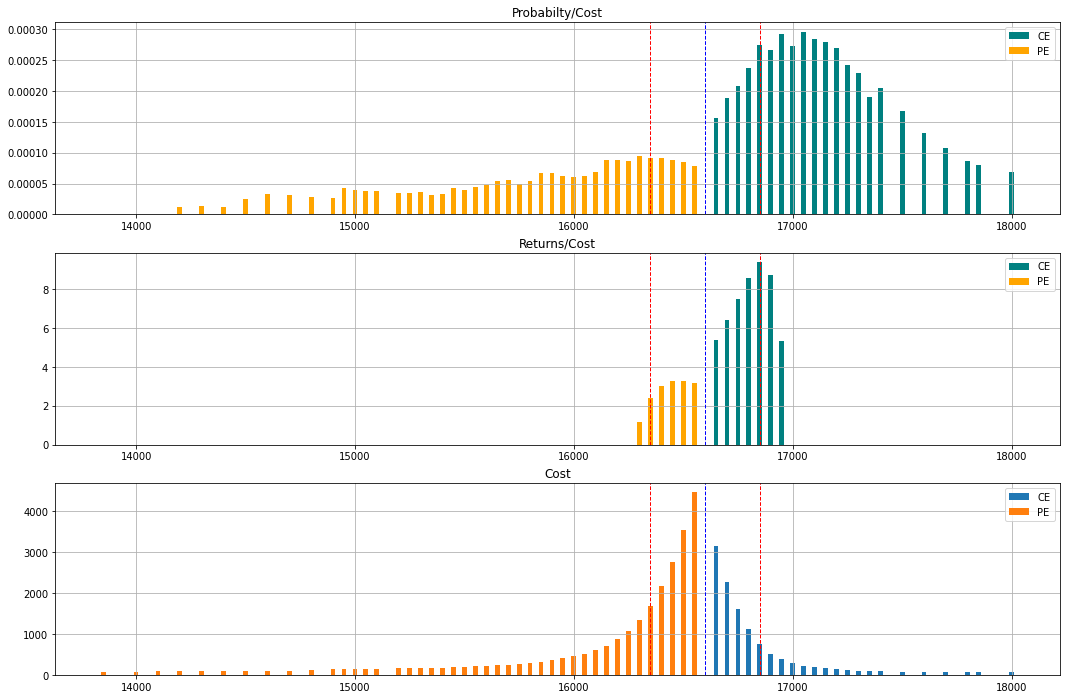

In [125]:
fig = plt.figure(figsize=(18,12))

ce_contract = 16850
pe_contract = 16350

ax = fig.add_subplot(311)
ax.set_title('Probabilty/Cost')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_atm_expiry_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=proba_atm_expiry_pe/cost_pe, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE')

plt.axvline(x=last_close, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=16850, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=16350, color='red', linewidth=1.0, linestyle='--')

ax.legend()
ax.grid()


ax = fig.add_subplot(312)

ax.set_title('Returns/Cost')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE')


plt.axvline(x=last_close, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=16850, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=16350, color='red', linewidth=1.0, linestyle='--')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/cost_pe, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE')

ax.legend()
ax.grid()


ax = fig.add_subplot(313)

ax.set_title('Cost')

# Zero out the loss making contracts
probable_profits_pe[probable_profits_pe<0] = 0
probable_profits_ce[probable_profits_ce<0] = 0

# Plot CE
ax.bar(x=strike_price_ce, 
       height=cost_ce, 
       width=22,  
       align='center', 
       label='CE')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=cost_pe, 
       width=22, 
       align='center', 
       label='PE')


plt.axvline(x=last_close, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=16850, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=16350, color='red', linewidth=1.0, linestyle='--')

ax.legend()
ax.grid()


Probabilty of  ~0.1 might not seem like much but if we calculate the cumulative probabilty over multiple trials (i.e. what would happen if we consistently made investments like this):

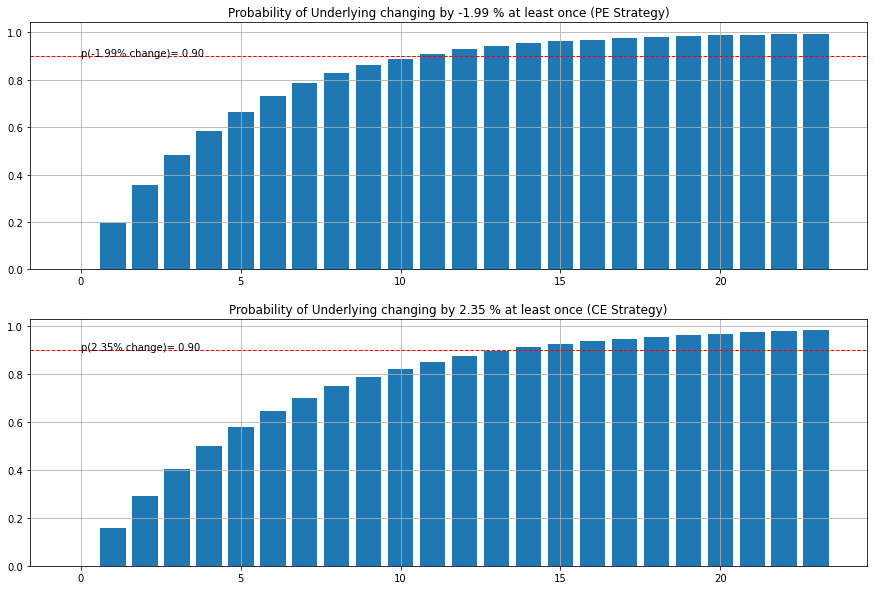

In [133]:
fig = plt.figure(figsize=(15,10))
threshold = 0.9
num_periods = range(24)

ax = fig.add_subplot(211)
ax.bar(num_periods,[1-(1-prob_change_neg_sigma)**(periods*2) for periods in num_periods])
plt.axhline(y=threshold, color='r', linewidth=1.0, linestyle='--')
plt.text(0,
         threshold,
         'p(%.2f%% change)= %.2f'%(expected_change_neg_sigma*100, threshold), 
         rotation=0)
ax.set_title('Probability of Underlying changing by %.2f %% at least once (PE Strategy)'% (100*expected_change_neg_sigma))
ax.grid()

ax = fig.add_subplot(212)
ax.bar(num_periods,[1-(1-prob_change_pos_sigma)**(periods*2) for periods in num_periods])
plt.axhline(y=threshold, color='r', linewidth=1.0, linestyle='--')
plt.text(0,
         threshold,
         'p(%.2f%% change)= %.2f'%(expected_change_pos_sigma*100, threshold), 
         rotation=0)
ax.set_title('Probability of Underlying changing by %.2f %% at least once (CE Strategy)'% (100*expected_change_pos_sigma))
ax.grid()

So probabilistically speaking:
- theres a 90% chance (P=0.9), the CE strategy will succeed at least once in 11 trials.
- theres a 90% chance (P=0.9), the PE strategy will succeed at least once in 15 trials.



**Question**: What is the probability of a strategy succeeding at least twice/thrice/__k__

### Laplace's Rule of Succession
Generalized to multinomial distributions.

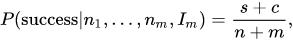




Where

- **s** : No. of successes
- **c** : No. of categories of outcomes which can be considered a success.
- **n** : No. of trials
- **m** : No. of categories of outcomes

In the case of the PE strategy:
- **s** is the count of when the underlying decreased by mean - standard deviation
- **c** is 1 as there is only one outcome where it succeeds
- **n** number of trials is equal to the number of windowed observations we have
- **m** is 4, if we consider 4 probable outcomes:
   - Contract(s) expire < `mean - standard deviation`
   - Contract(s) expire > `mean + standard deviation`
   - Contract(s) expire > 0 but, < `mean + standard deviation`
   - Contract(s) expire <= 0 but, > `mean - standard deviation`
        


In [151]:
s = (period_change < expected_change_neg_sigma).sum()
c = 1
n = len(period_change)
m = 4

(s+c)/(n+m)

0.10456062291434928

If we add our CE strategy into the mix to cover half of the outcome space, **c** becomes 2

In [152]:
s = ((period_change < expected_change_neg_sigma) | (period_change > expected_change_pos_sigma)).sum()
c = 2
n = len(period_change)
m = 4

(s+c)/(n+m)

0.18798665183537264

Cover 3/4th of the outcome space:

In [154]:
s = ((period_change < expected_change_neg_sigma) | (period_change > expected_change_pos_sigma) | (period_change > 0)).sum()
c = 3
n = len(period_change)
m = 4

(s+c)/(n+m)

0.6763070077864294

In [154]:
s = ((period_change < expected_change_neg_sigma) | (period_change > expected_change_pos_sigma) | (period_change > 0)).sum()
c = 3
n = len(period_change)
m = 4

(s+c)/(n+m)

0.6763070077864294

Probability of futures going up

In [153]:
s = (period_change > 0).sum()
c = 1
n = len(period_change)
m = 4

(s+c)/(n+m)

0.5706340378197998

CE Options Contract

In [141]:
s = (period_change > expected_change_pos_sigma).sum()
c = 1
n = len(period_change)
m = 5

(s+c)/(n+m)

0.08333333333333333

The scenario where CE, PE and FUT strategy all fail simultaneously:

In [156]:
s = ((period_change > expected_change_neg_sigma) & (period_change > 0)).sum()
c = 1
n = len(period_change)
m = 4

(s+c)/(n+m)

0.5706340378197998

# Next
- ~~Filter out OTM Options only~~
- ~~Calculate Probabilty/Cost~~
- ~~Calculate Returns/Cost~~
- Combine with cumulative probability
- Interactivity


### Interactivity Tests (WIP)

In [122]:
start_date = datetime(2018, 4, 24)
end_date = datetime(2018, 5, 24)

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

selection_range_slider

SelectionRangeSlider(description='Dates', index=(0, 30), layout=Layout(width='500px'), options=((' 24 Apr 2018…